## Fine-Tuning Convolutional Neural Networks to Classify Organic and Recyclable Materials with Keras, TensorFlow, and VGG-16.
#### - AMM '24

## Introduction
In this project, we will classify waste products using transfer learning and fine-tuning applied to a pre-trained VGG-16 model. 

### Project Overview

A hypothetical waste management company lacks an efficient and scalable method to automate the waste sorting process. The manual sorting of waste is not only labor-intensive but also prone to errors, leading to contamination of recyclable materials. The goal of this project is to leverage machine learning and computer vision to automate the classification of waste products, improving efficiency and reducing contamination rates. The project will use transfer learning and fine-tuning with a pre-trained VGG-16 model to classify images of organic and recyclable or inorganic material.



## Project Objectives

In this project, we will:

- Apply transfer learning using the VGG=16 model for image classification.
- Prepare and preprocess image data.
- Fine-tune a pre-trained model to improve classification accuracy.
- Evaluate the model’s performance using appropriate metrics.
- Visualize model predictions on test data.

We begin by installing our prerequisites:





### Installing Required Libraries


In [57]:
!pip install -q tensorflow==2.17.0 
!pip install -q numpy==1.24.3 
!pip install -q scikit-learn==1.5.1 
!pip install -q matplotlib==3.9.2

### Importing Required Libraries


In [58]:
import numpy as np
import os
import glob


from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')



## Creating a model for distinguishing recyclable (R) and organic (O) waste images

### Dataset

We will be using the [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01)     (DATA HERE) . The data is accessible by embedded link in the mention.

Our goal is to train an algorithm on these images and to predict the labels for images in our test set (1 = recyclable, 0 = organic).

### Importing Data

This will create a `o-vs-r-split` directory in our environment.


In [59]:
import requests
import zipfile
from tqdm import tqdm

url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/kd6057VPpABQ2FqCbgu9YQ/o-vs-r-split-reduced-1200.zip"
file_name = "o-vs-r-split-reduced-1200.zip"

print("Downloading file")
with requests.get(url, stream=True) as response:
    response.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


def extract_file_with_progress(file_name):
    print("Extracting file with progress")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        members = zip_ref.infolist() 
        with tqdm(total=len(members), unit='file') as progress_bar:
            for member in members:
                zip_ref.extract(member)
                progress_bar.update(1)
    print("Finished extracting file")


extract_file_with_progress(file_name)

print("Finished extracting file")
os.remove(file_name)

Extracting file with progress


100%|██████████| 1207/1207 [00:01<00:00, 727.34file/s]

Finished extracting file
Finished extracting file


### Defining configurations

It's time to define some model configuration options.

*   Our **batch size** is set to 32.
*   The **number of classes** is 2.
*   20% of the data for **validation** purposes.
*   2 **labels** in our dataset: organic (O), recyclable (R).


In [60]:
img_rows, img_cols = 150, 150
batch_size = 32
n_epochs = 10
n_classes = 2
val_split = 0.2
verbosity = 1
path = 'o-vs-r-split/train/'
path_test = 'o-vs-r-split/test/'
input_shape = (img_rows, img_cols, 3)
labels = ['O', 'R']
seed = 42

### Loading Images using ImageGeneratorClass

Usually transfer learning works best when models are trained on smaller datasets. 

Our folder structure looks as follows:

```python
o-vs-r-split/
└── train
    ├── O
    └── R
└── test
    ├── O
    └── R
```


#### ImageDataGenerators


Now we create ImageDataGenerators, used for training, validation and testing.



In [61]:
train_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
	width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    validation_split = val_split,
    rescale=1.0/255.0,
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [62]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'training'
)

Found 800 images belonging to 2 classes.


In [63]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=(img_rows, img_cols),
    subset = 'validation'
)

Found 200 images belonging to 2 classes.


In [64]:
test_generator = test_datagen.flow_from_directory(
    directory = path_test,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = False,
    target_size=(img_rows, img_cols),
)

Found 200 images belonging to 2 classes.


### Let's look at a few augmented images:


Labels: ['O', 'O', 'O', 'O', 'O']


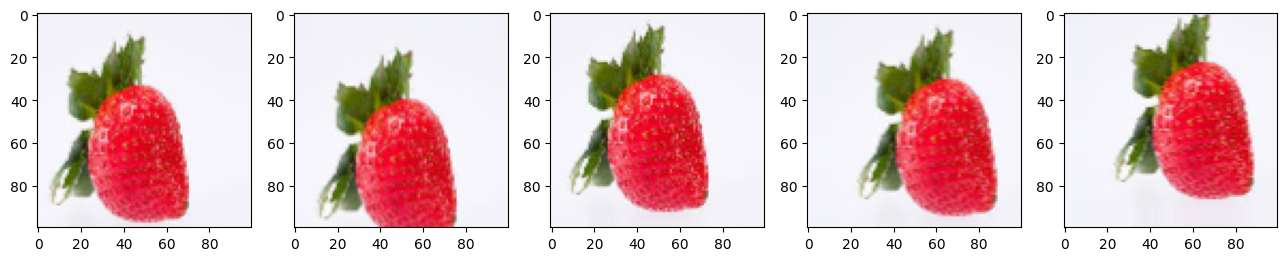

In [65]:
from pathlib import Path

IMG_DIM = (100, 100)

train_files = glob.glob('./o-vs-r-split/train/O/*')
train_files = train_files[:20]
train_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [Path(fn).parent.name for fn in train_files]

img_id = 0
O_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
O = [next(O_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in O])
l = [ax[i].imshow(O[i][0][0]) for i in range(0,5)]

### Pre-trained Models

Pre-trained models are saved models or networks that have previously been trained on some large datasets. They are typically used for large-scale image-classification tasks. They can be used as they are or could be customized to a given task using transfer learning and fine-tuning. These pre-trained models form the basis of transfer learning. We will now employ the VGG-16 model.

#### VGG-16

Let us load the VGG=16 model.


In [66]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

We flatten the output of the VGG model and assign it to the model `output`, we then use a Model object `basemodel` to group the layers into an object for training and inference with the following inputs and outputs

inputs: `vgg.input`

outputs: `tf.keras.layers.Flatten()(output)`


In [67]:
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

Next, we freeze the base model.


In [68]:
for layer in basemodel.layers: 
    layer.trainable = False

We create a new model on top and add a Dropout layer for regularization, only these layers will change, as for the lower layers we set `training=False` when calling the base model.


In [69]:
input_shape = basemodel.output_shape[1]

model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

### Let us see a summary of the model so far

In [70]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_42 (Functional)      │ (None, 8192)           │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,172,673 (73.14 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### We will now compile the model:

In [71]:
for layer in basemodel.layers: 
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer= optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy']
)

We use early stopping to avoid overfitting the model.


In [72]:
from tensorflow.keras.callbacks import LearningRateScheduler


checkpoint_path='O_R_tlearn_vgg16.keras'

# step decay function
class LossHistory_(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

## Fitting and training the model


In [73]:
extract_feat_model = model.fit(train_generator, 
                               steps_per_epoch=5, 
                               epochs=10,
                               callbacks = callbacks_list_,   
                               validation_data=val_generator, 
                               validation_steps=val_generator.samples // batch_size, 
                               verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4332 - loss: 0.8556lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 10s/step - accuracy: 0.4412 - loss: 0.8499 - val_accuracy: 0.5781 - val_loss: 0.6154 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6801 - loss: 0.6625lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6782 - loss: 0.6577 - val_accuracy: 0.6250 - val_loss: 0.6551 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6303 - loss: 0.6272lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - accuracy: 0.6430 - loss: 0.6170 - val_accuracy: 0.8385 - val_loss: 0.4925 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7093 - loss: 0.5592lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7129 - loss: 0.5549 - val_accuracy: 1.0000 - val_loss: 0.3938 - learning_rate: 7.4082e-05
Epoch 5/10


### Plotting loss curves for training and validation sets


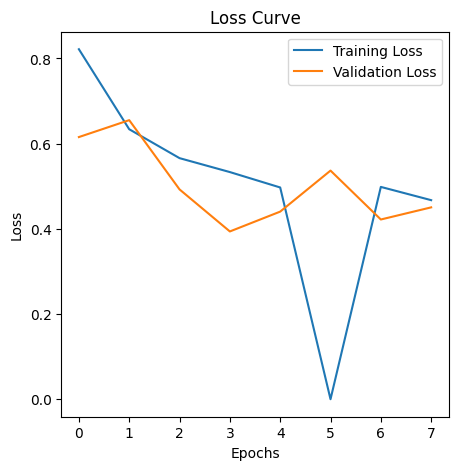

In [74]:
import matplotlib.pyplot as plt

history = extract_feat_model

plt.figure(figsize=(5, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plotting accuracy curves for training and validation sets 


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.7909 - loss: 0.4327 - val_accuracy: 0.8600 - val_loss: 0.3465 - learning_rate: 4.9659e-05
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.8428 - loss: 0.3805 - val_accuracy: 0.8400 - val_loss: 0.3169 - learning_rate: 4.9659e-05
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8715 - loss: 0.3273 - val_accuracy: 0.8700 - val_loss: 0.2906 - learning_rate: 4.9659e-05
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.8904 - loss: 0.2874 - val_accuracy: 0.8900 - val_loss: 0.2683 - learning_rate: 4.9659e-05
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.8548 - loss: 0.3094 - val_accuracy: 0.8600 - val_loss: 0.2655 - learning_rate: 4.9659e-05


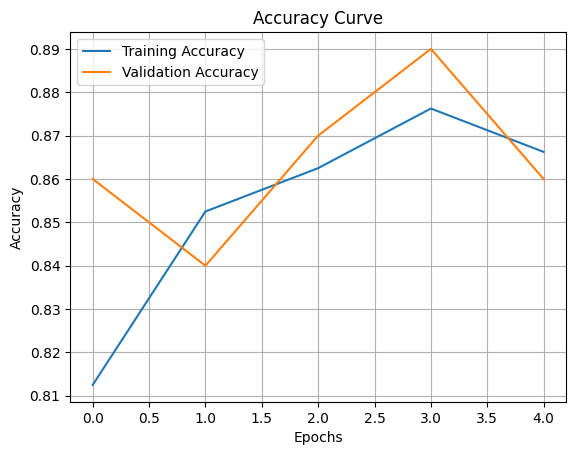

In [75]:
import matplotlib.pyplot as plt

history = extract_feat_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

# learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[lr_scheduler]
)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Fine-Tuning our model

Fine-tuning is an optional step in transfer learning, it usually ends up improving the performance of the model. 

We will **unfreeze** one layer from the base model and train the model again.


In [76]:
from tensorflow.keras.applications import vgg16

input_shape = (150, 150, 3)
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=input_shape)

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
basemodel = Model(vgg.input, output)

for layer in basemodel.layers: 
    layer.trainable = False

display([layer.name for layer in basemodel.layers])

set_trainable = False

for layer in basemodel.layers:
    if layer.name in ['block5_conv3']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in basemodel.layers:
    print(f"{layer.name}: {layer.trainable}")

['input_layer_8',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten_4']

input_layer_8: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: False
block5_conv2: False
block5_conv3: True
block5_pool: True
flatten_4: True


Similar to what we did before, we will create a new model on top, and add a Dropout layer for regularization.


In [77]:
model = Sequential()
model.add(basemodel)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

checkpoint_path='O_R_tlearn_fine_tune_vgg16.keras'

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

keras_callbacks = [
      EarlyStopping(monitor = 'val_loss', 
                    patience = 4, 
                    mode = 'min', 
                    min_delta=0.01),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]

callbacks_list_ = [loss_history_, lrate_] + keras_callbacks

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

fine_tune_model = model.fit(train_generator, 
                    steps_per_epoch=5, 
                    epochs=10,
                    callbacks = callbacks_list_,   
                    validation_data=val_generator, 
                    validation_steps=val_generator.samples // batch_size, 
                    verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4669 - loss: 0.9409lr: 9.048374180359596e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.4734 - loss: 0.9256 - val_accuracy: 0.7969 - val_loss: 0.5801 - learning_rate: 1.0000e-04
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6653 - loss: 0.6245lr: 8.187307530779819e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6648 - loss: 0.6219 - val_accuracy: 0.7500 - val_loss: 0.5041 - learning_rate: 9.0484e-05
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7607 - loss: 0.5029lr: 7.408182206817179e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 8s/step - accuracy: 0.7631 - loss: 0.5019 - val_accuracy: 0.7917 - val_loss: 0.4722 - learning_rate: 8.1873e-05
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8161 - loss: 0.4335lr: 6.703200460356394e-05
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8103 - loss: 0.4410 - val_accuracy: 1.0000 - val_loss: 0.3586 - learning_rate: 7.4082e-05
Epoch 5/10
5

### Plotting loss curves for training and validation sets (fine-tuned model)


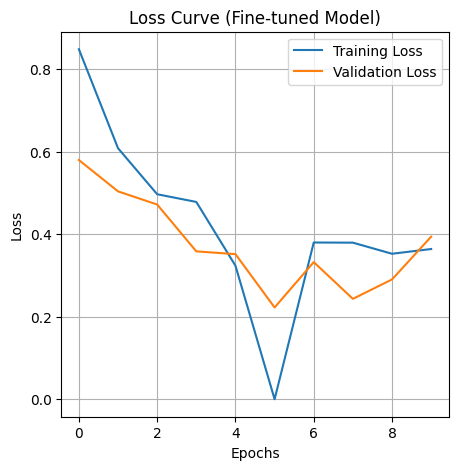

In [78]:
history = fine_tune_model

plt.figure(figsize=(5,5))
plt.plot(fine_tune_model.history['loss'], label='Training Loss')
plt.plot(fine_tune_model.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve (Fine-tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Plotting accuracy curves for training and validation sets (fine-tuned model)


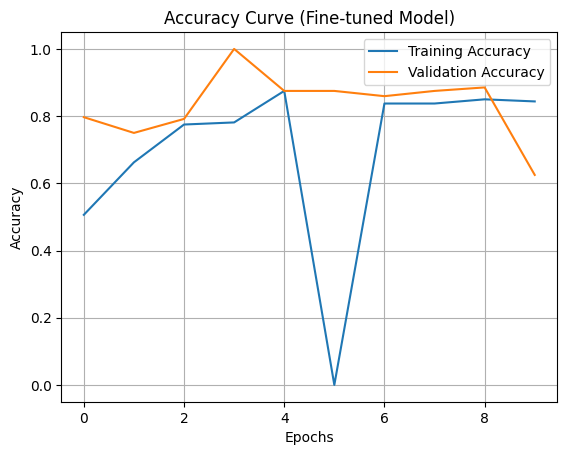

In [79]:
history = fine_tune_model

plt.plot(fine_tune_model.history['accuracy'], label='Training Accuracy')
plt.plot(fine_tune_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve (Fine-tuned Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluating both models on test data
We will now:
- Load saved models
- Load test images
- Make predictions for both models
- Convert predictions to class labels
- Print classification reports for both models


In [80]:
from pathlib import Path

# Load saved models
extract_feat_model = tf.keras.models.load_model('O_R_tlearn_vgg16.keras')
fine_tune_model = tf.keras.models.load_model('O_R_tlearn_fine_tune_vgg16.keras')

IMG_DIM = (150, 150)

# Load test images
test_files_O = glob.glob('./o-vs-r-split/test/O/*')
test_files_R = glob.glob('./o-vs-r-split/test/R/*')
test_files = test_files_O[:50] + test_files_R[:50]

test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [Path(fn).parent.name for fn in test_files]

# Standardizing
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

class2num_lt = lambda l: [0 if x == 'O' else 1 for x in l]
num2class_lt = lambda l: ['O' if x < 0.5 else 'R' for x in l]

test_labels_enc = class2num_lt(test_labels)

# Make predictions for both models
predictions_extract_feat_model = extract_feat_model.predict(test_imgs_scaled, verbose=0)
predictions_fine_tune_model = fine_tune_model.predict(test_imgs_scaled, verbose=0)

# Convert predictions to class labels
predictions_extract_feat_model = num2class_lt(predictions_extract_feat_model)
predictions_fine_tune_model = num2class_lt(predictions_fine_tune_model)

# Print classification reports for both models
print('Extract Features Model')
print(metrics.classification_report(test_labels, predictions_extract_feat_model))
print('Fine-Tuned Model')
print(metrics.classification_report(test_labels, predictions_fine_tune_model))

Extract Features Model
              precision    recall  f1-score   support

           O       0.83      0.68      0.75        50
           R       0.73      0.86      0.79        50

    accuracy                           0.77       100
   macro avg       0.78      0.77      0.77       100
weighted avg       0.78      0.77      0.77       100

Fine-Tuned Model
              precision    recall  f1-score   support

           O       0.77      0.86      0.81        50
           R       0.84      0.74      0.79        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



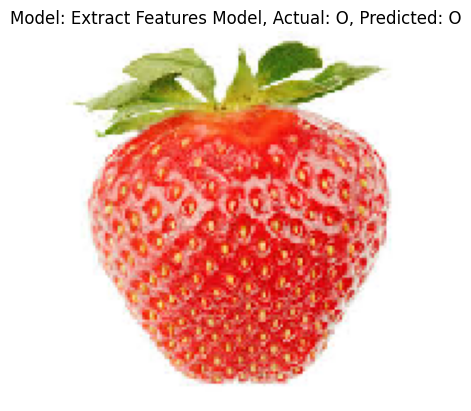

In [81]:
# Plotting one of the images with actual label and predicted label as title
def plot_image_with_title(image, model_name, actual_label, predicted_label):
    plt.imshow(image)
    plt.title(f"Model: {model_name}, Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# index of image to plot
index_to_plot = 0
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

### Plotting a test image using Extract Features Model

**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘O’, the prediction could be either ‘O’ or ‘R’, both of which are possible outcomes in images with mixed organic and inorganic materials!


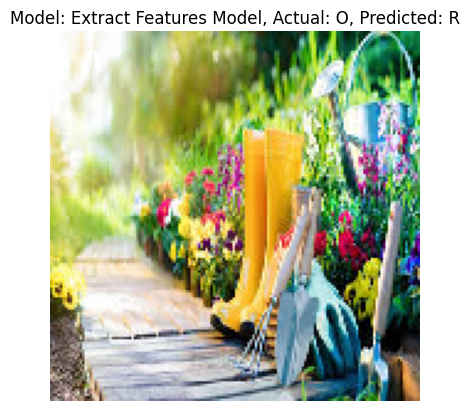

In [82]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Extract Features Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_extract_feat_model[index_to_plot],
    )

### Plotting a test image using our Fine-Tuned Model 

**NOTE**: Due to the inherent nature of neural networks, predictions may vary from the actual labels. For instance, if the actual label is ‘O’, the prediction could be either ‘O’ or ‘R’, both of which are still possible outcomes as before!


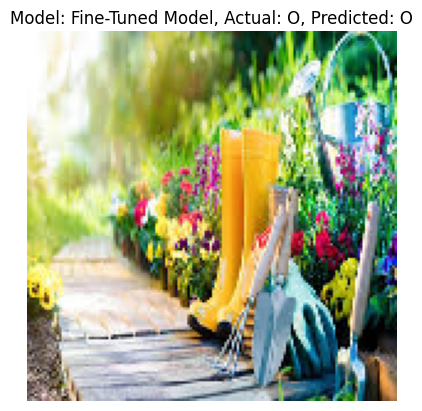

In [83]:
index_to_plot = 1
plot_image_with_title(
    image=test_imgs[index_to_plot].astype('uint8'),
    model_name='Fine-Tuned Model',
    actual_label=test_labels[index_to_plot], 
    predicted_label=predictions_fine_tune_model[index_to_plot],
    )

#### Our model has made an improvement in performance after fine-tuning, illustrating the importance of fine-tuning in the model training process, and implying a diverse range of increasingly niche applications for fine-tuned existing models as AI and ML practices become more commonplace in industry, with applications of our model extending from waste and recycling management to agricultural and farming activites.